# TinyML Lab 2: Quantization and Pruning Methods for TinyML

Welcome to the TinyML Lab2! In this lab, we will first go through three (post training) quantization methods: (1) Float-16 Quantization, (2) Dynamic Range Quantization, and (3) Integer Quantization. Then we try out pruning for model compression.

We will use Efficient Net (`efnet`) ML model as our base ML model and download and use `cats_vs_dogs` dataset for training and testing ML models.

Before working on the code, we will need to install  `tensoflow` for this lab. The following code will display the current version of the tensorflow if you have already installed it in your machine.

In [1]:
pip show tensorflow

Name: tensorflow
Version: 2.15.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine-rl, tf_keras


In the following we will install `tensorflow_datasets` and `tensorflow_model_optimization` libraries.

In [3]:
pip install tensorflow_datasets

In [4]:
pip install tensorflow_model_optimization

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 1.6 MB/s eta 0:00:00


Next we will first download and load `cats_vs_dogs` dataset, load and retrain `efnet` ML model, and experiment with three (post training) quantization methods: (1) Float-16 Quantization, (2) Dynamic Range Quantization, and (3)Integer Quantization.  

In [6]:
# Importing necessary libraries and packages.
import os
import numpy as np
import tempfile
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from tensorflow.keras.models import Model
import tensorflow_model_optimization as tfmot
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dropout, Dense, BatchNormalization

## (1) Preparing the Dataset

We can directly import the dataset from the TensorFlow Dataset (tfds). Here we will split the dataset into training, validation, and testing set with a split ratio of 0.7:0.2:0.1. The as_supervised parameter is kept True as we need the labels of the images for classification.

In [7]:
# Downloading and Loading the CatvsDog dataset.
(train_ds, val_ds, test_ds), info = tfds.load('cats_vs_dogs', split=['train[:70%]', 'train[70%:90%]', 'train[90%:]'], shuffle_files=True, as_supervised=True, with_info=True)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/4.0.1.incompleteDACX3G/cats_vs_dogs-train.tfrecord*...:   0%|…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


Let us now have a look at the dataset information provided in tfds.info(). The dataset has two classes labelled as ‘cat’ and ‘dog’ with 16283, 4653, 2326 training, validation and testing images.

In [8]:
# Obtaining dataset information.
print("Number of  Classes: " + str(info.features['label'].num_classes))
print("Classes : " + str(info.features['label'].names))
NUM_TRAIN_IMAGES = tf.data.experimental.cardinality(train_ds).numpy()
print("Training Images: " + str(NUM_TRAIN_IMAGES))
NUM_VAL_IMAGES = tf.data.experimental.cardinality(val_ds).numpy()
print("Validation Images: " + str(NUM_VAL_IMAGES))
NUM_TEST_IMAGES = tf.data.experimental.cardinality(test_ds).numpy()
print("Testing Images: " + str(NUM_TEST_IMAGES))

Number of  Classes: 2
Classes : ['cat', 'dog']
Training Images: 16283
Validation Images: 4653
Testing Images: 2326


The function tfds.visualization.show_examples() function displays images and their corresponding labels. It comes very handy when we want to visualize a few images in a single line of code!

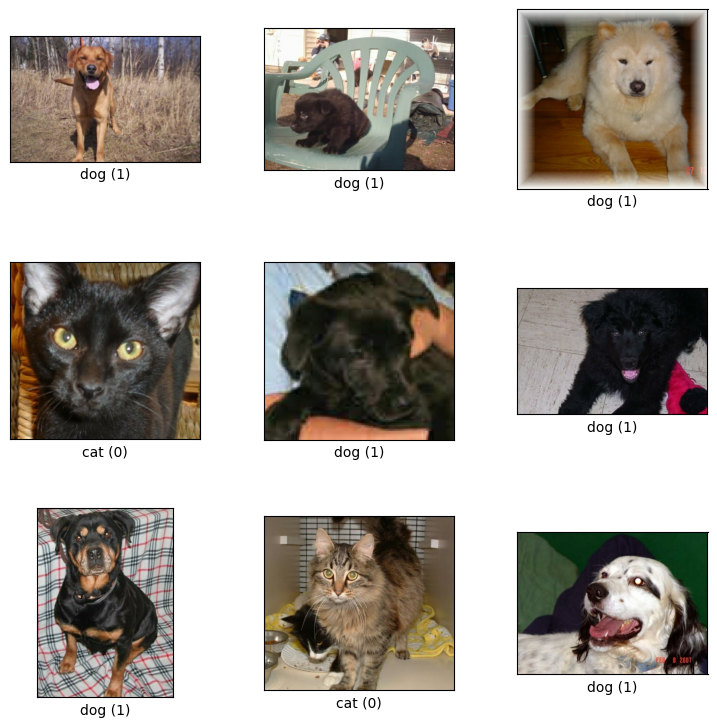

In [9]:
# Visualizing the training dataset.import tempfile
vis = tfds.visualization.show_examples(train_ds, info)

We have chosen 16 as batch size and 224×224 as image size so that the dataset can be processed effectively and efficiently. To prepare the dataset, the images have been resized accordingly.
Let’s also make sure to use buffered prefetching to yield data from the disk. Prefetching overlaps the preprocessing and model execution of a training step. Doing so reduces the step time to the training and the time it takes to extract the data.

In [10]:
# Defining batch-size and input image size.
batch_size = 16
img_size = [224, 224]# Resizing images in the dataset.
train_ds_ = train_ds.cache().map(lambda x, y: (tf.image.resize(x, img_size), y)).batch(batch_size).prefetch(buffer_size=10)
# TODO: Resize the validation dataset and testing dataset
val_ds_ = val_ds.cache().map(lambda x, y: (tf.image.resize(x, img_size), y)).batch(batch_size).prefetch(buffer_size=10)
test_ds_ = test_ds.cache().map(lambda x, y: (tf.image.resize(x, img_size), y)).batch(batch_size).prefetch(buffer_size=10)

To feed images to the TF Lite model, we need to extract the test images and their labels. We will store them into variables and feed them to TF Lite for evaluation.

In [11]:
# Extracting and saving test images and labels from the test dataset.
test_images = []
test_labels = []
for image, label in test_ds_.take(len(test_ds_)).unbatch():
    test_images.append(image)
    test_labels.append(label)

## (2) Loading the Model

We have chosen the EfiicientNet B0 model pre-trained on the imagenet dataset for image classification purposes. EfficientNet is a state-of-the-art image classification model. It significantly outperforms other ConvNets.

Let us import the model form tf.keras.applications().  The last layer has been removed by setting include_top = False .We have set the input image size to 224×224 pixels and kept the pooling layer to be GlobalMaxPooling2D. Let’s load the model and unfreeze all the layers to make them trainable.

In [12]:
# Defining the model architecture.
efnet = tf.keras.applications.EfficientNetB0(include_top = False, weights ='imagenet', input_shape = (224, 224, 3), pooling = 'max')# Unfreezing all the layers of the model.
for layer in efnet.layers:
    set_trainable = True

16705208/16705208 [==============================] - 0s 0us/step


Now, we will add a Dense layer to the pre-trained model and train it. This layer will become the last layer, or the inference layer. We will also add Dropout and BatchNormalization to reduce overfitting.

In [13]:
# Adding Dense, BatchNormalization and Dropout layers to the base model.
x = Dense(512, activation='relu')(efnet.output)
x = BatchNormalization()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(2, activation='softmax')(x)

# You can play with different dropout ratios, dimensions and BatchNormalization
# For exmaple:
# Dropout -> 0.7
# Dimensions -> 128, 16
# Remove BatchNormalization

## (3) Compiling the Model

We are ready to compile the model. We have used Adam Optimizer with an initial learning rate of 0.0001, sparse categorical cross-entropy as the loss function, and accuracy as the metric. Once compiled, we check the model summary.

In [14]:
# Defining the input and output layers of the model.
model = Model(inputs=efnet.input, outputs=predictions)

# Compiling the model.
model.compile(optimizer=tf.keras.optimizers.Adam(0.0001), loss =tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics = ["accuracy"])

# Obtaining the model summary.
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 224, 224, 3)          0         ['normalization[0][0]']   

We are using Model Saving Callback and the Reduce LR Callback.

(i) Model Saving Callback saves the model with the best validation accuracy

(ii) Reduce LR Callback reduces the learning rate by a factor of 0.1 if validation loss remains the same for three consecutive epochs.

In [15]:
# Defining file path of the saved model.
filepath = 'model.h5'

# Defining Model Save Callback and Reduce Learning Rate Callback.
model_save = tf.keras.callbacks.ModelCheckpoint(
    filepath,
    monitor="val_accuracy",
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode="max",
    save_freq="epoch")

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, patience=3, verbose=1, min_delta=5*1e-3,min_lr =5*1e-9,)

callback = [model_save, reduce_lr]

## (4) Training the Model

The method `model.fit()` is called to train the model. We pass the training and validation datasets and train the model for 15 epochs.

In [16]:
# Training the model for 15 epochs.
# ---> epoch = 3 for testing the code and saving time during the lab
# ---> epoch = 15 recommended for better results
model.fit(train_ds_, epochs=3, steps_per_epoch=(len(train_ds_)//batch_size), validation_data=val_ds_, validation_steps=(len(val_ds_)//batch_size), shuffle=False, callbacks=callback)

Epoch 1/3
63/63 [==============================] - ETA: 0s - loss: 0.4070 - accuracy: 0.8165

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


63/63 [==============================] - 59s 224ms/step - loss: 0.4070 - accuracy: 0.8165 - val_loss: 0.0955 - val_accuracy: 0.9688 - lr: 1.0000e-04
Epoch 2/3
63/63 [==============================] - 11s 169ms/step - loss: 0.2128 - accuracy: 0.9167 - val_loss: 0.0709 - val_accuracy: 0.9722 - lr: 1.0000e-04
Epoch 3/3
63/63 [==============================] - 10s 167ms/step - loss: 0.1354 - accuracy: 0.9484 - val_loss: 0.0538 - val_accuracy: 0.9757 - lr: 1.0000e-04


## (5) Evaluating the Model

Done training! Let’s check the model’s performance on the test set.

In [17]:
# Evaluating the model on the test dataset.
_, baseline_model_accuracy = model.evaluate(test_ds_, verbose=0)
print('Baseline test accuracy:', baseline_model_accuracy*100)

Baseline test accuracy: 98.40928912162781


## (6) Float-16 Quantization
In Float-16 quantization, weights are converted to 16-bit floating-point values.

In [18]:
# Passing the Keras model to the TF Lite Converter.
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Using float-16 quantization.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]

# Converting the model.
tflite_fp16_model = converter.convert()

# Saving the model.
with open('fp_16_model.tflite', 'wb') as f:
    f.write(tflite_fp16_model)

# Print the model size
model_size = os.path.getsize('fp_16_model.tflite')
print(f"Model size: {model_size} bytes = {model_size/1024/1024} MB")

Model size: 9455684 bytes = 9.017642974853516 MB


We have passed the Float 16 quantization the `converter.target_spec.supported_type` to specify the type of quantization. The rest of the code remains the same for a general way of conversion for the TF Lite Model. In order to get model accuracy, let’s first define evaluate() function that takes in tflite model and returns model accuracy.

In [19]:
#Function for evaluating TF Lite Model over Test Images
def evaluate(interpreter):
    prediction= []
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]
    input_format = interpreter.get_output_details()[0]['dtype']

    for i, test_image in enumerate(test_images):
        if i % 100 == 0:
            print('Evaluated on {n} results so far.'.format(n=i))
        test_image = np.expand_dims(test_image, axis=0).astype(input_format)
        interpreter.set_tensor(input_index, test_image)

        # Run inference.
        interpreter.invoke()
        output = interpreter.tensor(output_index)
        predicted_label = np.argmax(output()[0])
        prediction.append(predicted_label)

    print('\n')
    # Comparing prediction results with ground truth labels to calculate accuracy.
    prediction = np.array(prediction)
    accuracy = (prediction == test_labels).mean()
    return accuracy

Check this FP-16 Quantized TF Lite’s model performance on the Test Set.

In [20]:
# Passing the FP-16 TF Lite model to the interpreter.
interpreter = tf.lite.Interpreter('fp_16_model.tflite')
# Allocating tensors.
interpreter.allocate_tensors()
# Evaluating the model on the test dataset.
test_accuracy = evaluate(interpreter)
print('Float 16 Quantized TFLite Model Test Accuracy:', test_accuracy*100)
print('Baseline Keras Model Test Accuracy:', baseline_model_accuracy*100)

Evaluated on 0 results so far.
Evaluated on 100 results so far.
Evaluated on 200 results so far.
Evaluated on 300 results so far.
Evaluated on 400 results so far.
Evaluated on 500 results so far.
Evaluated on 600 results so far.
Evaluated on 700 results so far.
Evaluated on 800 results so far.
Evaluated on 900 results so far.
Evaluated on 1000 results so far.
Evaluated on 1100 results so far.
Evaluated on 1200 results so far.
Evaluated on 1300 results so far.
Evaluated on 1400 results so far.
Evaluated on 1500 results so far.
Evaluated on 1600 results so far.
Evaluated on 1700 results so far.
Evaluated on 1800 results so far.
Evaluated on 1900 results so far.
Evaluated on 2000 results so far.
Evaluated on 2100 results so far.
Evaluated on 2200 results so far.
Evaluated on 2300 results so far.


Float 16 Quantized TFLite Model Test Accuracy: 98.40928632846088
Baseline Keras Model Test Accuracy: 98.40928912162781


## (7) Dynamic Range Quantization

In Dynamic Range Quantization, weights are converted to 8-bit precision values.

In [21]:
# Passing the baseline Keras model to the TF Lite Converter.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
# Using the Dynamic Range Quantization.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Converting the model
tflite_quant_model = converter.convert()
# Saving the model.
with open('dynamic_quant_model.tflite', 'wb') as f:
    f.write(tflite_quant_model)

# Print the model size
model_size = os.path.getsize('dynamic_quant_model.tflite')
print(f"Model size: {model_size} bytes = {model_size/1024/1024} MB")

Model size: 5229536 bytes = 4.987274169921875 MB


Let’s evaluate this TF Lite model on the test dataset.

In [22]:
# TODO: Passing the Dynamic Range Quantized TF Lite model to the Interpreter.
drq_interpreter = tf.lite.Interpreter('dynamic_quant_model.tflite')

# TODO: Allocating tensors.
drq_interpreter.allocate_tensors()

# TODO: Evaluating the model on the test images.
drq_test_accuracy = evaluate(drq_interpreter)
print('Dynamic Range Quantization TFLite Model Test Accuracy:', drq_test_accuracy*100)
print('Baseline Keras Model Test Accuracy:', baseline_model_accuracy*100)

Evaluated on 0 results so far.
Evaluated on 100 results so far.
Evaluated on 200 results so far.
Evaluated on 300 results so far.
Evaluated on 400 results so far.
Evaluated on 500 results so far.
Evaluated on 600 results so far.
Evaluated on 700 results so far.
Evaluated on 800 results so far.
Evaluated on 900 results so far.
Evaluated on 1000 results so far.
Evaluated on 1100 results so far.
Evaluated on 1200 results so far.
Evaluated on 1300 results so far.
Evaluated on 1400 results so far.
Evaluated on 1500 results so far.
Evaluated on 1600 results so far.
Evaluated on 1700 results so far.
Evaluated on 1800 results so far.
Evaluated on 1900 results so far.
Evaluated on 2000 results so far.
Evaluated on 2100 results so far.
Evaluated on 2200 results so far.
Evaluated on 2300 results so far.


Dynamic Range Quantization TFLite Model Test Accuracy: 97.93637145313843
Baseline Keras Model Test Accuracy: 98.40928912162781


## (8) Integer Quantization

Integer quantization is an optimization strategy that converts 32-bit floating-point numbers (such as weights and activation outputs) to the nearest 8-bit fixed-point numbers. This resulted in a smaller model and increased inferencing speed, which is valuable for low-power devices such as microcontrollers.

The integer quantization requires a representative dataset, i.e. a few images from the training dataset, for the conversion to happen.

In [23]:
# Passing the baseline Keras model to the TF Lite Converter.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
# Defining the representative dataset from training images.
def representative_data_gen():
    for input_value in tf.data.Dataset.from_tensor_slices(test_images).take(100):
        yield [input_value]

converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen

# Using Integer Quantization.
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8, tf.lite.OpsSet.SELECT_TF_OPS]

# Setting the input and output tensors to uint8.
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
# Converting the model.
int_quant_model = converter.convert()

# Saving the Integer Quantized TF Lite model.
with open('int_quant_model.tflite', 'wb') as f:
    f.write(int_quant_model)

# Print the model size
model_size = os.path.getsize('int_quant_model.tflite')
print(f"Model size: {model_size} bytes = {model_size/1024/1024} MB")

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Model size: 5591096 bytes = 5.332084655761719 MB


Let’s evaluate the obtained Integer Quantized TF Lite model on the test dataset.

In [24]:
# TODO: Passing the Integer Quantized TF Lite model to the Interpreter.
int_interpreter = tf.lite.Interpreter('int_quant_model.tflite')

# TODO: Allocating tensors.
int_interpreter.allocate_tensors()

# TODO: Evaluating the model on the test images.
int_test_accuracy = evaluate(drq_interpreter)
print('Integer Quantization TFLite Model Test Accuracy:', int_test_accuracy*100)
print('Baseline Keras Model Test Accuracy:', baseline_model_accuracy*100)


Evaluated on 0 results so far.
Evaluated on 100 results so far.
Evaluated on 200 results so far.
Evaluated on 300 results so far.
Evaluated on 400 results so far.
Evaluated on 500 results so far.
Evaluated on 600 results so far.
Evaluated on 700 results so far.
Evaluated on 800 results so far.
Evaluated on 900 results so far.
Evaluated on 1000 results so far.
Evaluated on 1100 results so far.
Evaluated on 1200 results so far.
Evaluated on 1300 results so far.
Evaluated on 1400 results so far.
Evaluated on 1500 results so far.
Evaluated on 1600 results so far.
Evaluated on 1700 results so far.
Evaluated on 1800 results so far.
Evaluated on 1900 results so far.
Evaluated on 2000 results so far.
Evaluated on 2100 results so far.
Evaluated on 2200 results so far.
Evaluated on 2300 results so far.


Integer Quantization TFLite Model Test Accuracy: 97.93637145313843
Baseline Keras Model Test Accuracy: 98.40928912162781


## (9) Model Pruning

You will apply pruning to the whole model and see this in the model summary. In this example, you start the model with 50% sparsity (50% zeros in weights) and end with 80% sparsity. Also note that pruning can be only applied to the dense layers.

In [25]:
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Compute end step to finish pruning after 2 epochs.
batch_size = 16
epochs = 2
#validation_split = 0.1 # 10% of training set will be used for validation set.

num_images = NUM_TRAIN_IMAGES#train_images.shape[0] * (1 - validation_split)
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.80,
                                                               begin_step=0,
                                                               end_step=end_step)
}

def apply_pruning_to_dense(layer):
    if isinstance(layer, tf.keras.layers.Dense):
        return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
    return layer

# Use `tf.keras.models.clone_model` to apply `apply_pruning_to_dense`
# to the layers of the model.
model_for_pruning = tf.keras.models.clone_model(
    model,
    clone_function=apply_pruning_to_dense,
)

# model_for_pruning = prune_low_magnitude(model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
model_for_pruning.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_for_pruning.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling[1][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 224, 224, 3)          0         ['normalization[1][0]']   

### Discussion: Why number of parameters increase after prunning ?


Note that Pruning doesn't change the original model's structure. So it is not meant to reduce the number of parameters. Pruning is a model optimization technique that eliminates not commonly used (i.e., unnecessary) values in the weights.

Pruned model summary shows the parameters added for pruning. They are the non-trainable parameters. Non-trainable parameters stand for masking. Tensorflow adds non-trainable masks to each of the weights in the network to specify which of the weights should be pruned. The masks consist of 0s (remove weight) and 1s (keep weight).

In [26]:
logdir = tempfile.mkdtemp()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

model_for_pruning.fit(train_ds_, epochs=3, steps_per_epoch=(len(train_ds_)//batch_size), validation_data=val_ds_, validation_steps=(len(val_ds_)//batch_size), shuffle=False, callbacks=callbacks)
# model_for_pruning.fit(train_ds_,
#                   batch_size=batch_size, epochs=epochs, validation_split=validation_split,
#                   callbacks=callbacks)

Epoch 1/3


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


 6/63 [=>............................] - ETA: 8s - loss: 0.2252 - accuracy: 0.9062

63/63 [==============================] - 52s 194ms/step - loss: 0.3059 - accuracy: 0.8800 - val_loss: 0.8300 - val_accuracy: 0.7951
Epoch 2/3
63/63 [==============================] - 14s 229ms/step - loss: 0.2063 - accuracy: 0.9137 - val_loss: 0.2159 - val_accuracy: 0.9410
Epoch 3/3
63/63 [==============================] - 10s 159ms/step - loss: 0.1503 - accuracy: 0.9494 - val_loss: 0.1500 - val_accuracy: 0.9583


In [27]:
# TODO: Evaluate the pruned model using "model_for_pruning / clone_model in Tensorflow Lite"
_, model_for_pruning_accuracy = model_for_pruning.evaluate(test_ds_, verbose=0)

print('Baseline test accuracy:', baseline_model_accuracy)
print('Pruned test accuracy:', model_for_pruning_accuracy)

Baseline test accuracy: 0.9840928912162781
Pruned test accuracy: 0.9565778374671936
